# Structure Similarity Embedding

## Set Up

In [1]:
# !pip install rdkit
# !pip install gensim

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
%cd ..

D:\OneDrive\w210\capstone-project


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
import json
import pickle
import gensim

import seaborn as sns
import matplotlib.pyplot as plt

# CLustering
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from matplotlib.colors import LogNorm

# pd.options.display.float_format = '{:,.3f}'.format()
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)
sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Extract Fingerprints & Similarity

In [4]:
def get_fingerprints(smiles, verbose=False, fingerprints='Morgan'):
    # Encode to molecule object
    mol = Chem.MolFromSmiles(smiles)

    if fingerprints == 'Morgan':
        # Generate morgan fingerprint
        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        except:
            fp = None

    if fingerprints == 'MACCS':
        # SMARTS-based MACCS Keys which is a simplified version (less bits) 166 keys
        try:
            fp = MACCSkeys.GenMACCSKeys(mol)
        except:
            fp = None

    if fingerprints == 'RDKit':
        # Topological Fingerprints
        try:
            fp = AllChem.RDKFingerprint(mol)
        except:
            fp = None

    if verbose:
        print('Fingerprint', fp.ToBitString())

    return fp

In [5]:
def BraunBlanquetSimilarity(fp1, fp2):
    """Calculate Braun-Blanquet Similarity"""
    # Count the number of bits that are both 1 in the two fingerprints
    intersection = set(fp1.GetOnBits()) & set(fp2.GetOnBits())
    # Count the number of bits that are 1 in the larger fingerprint
    union = max(fp1.GetNumOnBits(), fp2.GetNumOnBits())
    # Return the ratio of intersection to union
    if union > 0:
        return len(intersection) / union
    else:
        return None


def get_similarity(fp1, fp2, metric="Tanimoto"):
    if not fp1 or not fp2:
        return None

    if metric == "Tanimoto": #Jaccard
        return DataStructs.TanimotoSimilarity(fp1, fp2)

    if metric == "Braun-Blanquet":
        return BraunBlanquetSimilarity(fp1, fp2)

    if metric == "Dice":
        return DataStructs.DiceSimilarity(fp1, fp2)

    if metric == "Cosine":
        return DataStructs.CosineSimilarity(fp1, fp2)

In [33]:
# fp1.ToBitString()
# fp1.GetNumOnBits()
# set(fp1.GetOnBits())
# set(np.nonzero(np.array(fp1))[0])
# fp1_arr

In [6]:
### TEST BLOCK
smiles1 = 'COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C'
smiles2 = 'CN(C)CCCC1(OCC2=C1C=CC(=C2)C#N)C1=CC=C(F)C=C1'

## Morgan fingerprint
print('Morgan Fingerprints:')
fp1 = get_fingerprints(smiles1, fingerprints='Morgan')
fp2 = get_fingerprints(smiles2, fingerprints='Morgan')

sim_tan = get_similarity(fp1, fp2, metric="Tanimoto")
sim_bb = get_similarity(fp1, fp2, metric="Braun-Blanquet")
sim_dice = get_similarity(fp1, fp2, metric="Dice")
sim_cosine = get_similarity(fp1, fp2, metric="Cosine")
# sim2 = DataStructs.FingerprintSimilarity(fp1, fp2)  ## FingerprintSimilarity is actually equal to Tanimoto

print('Tanimoto Similarity:', sim_tan)
print('Braun-Blanquet Similarity:', sim_bb)
print('Dice Similarity:', sim_dice)
print('Cosine Similarity:', sim_cosine)

## Manual calculation using Numpy array
fp1_arr = np.array(fp1)
fp2_arr = np.array(fp2)

def ConsineSimilarity(fp1_arr, fp2_arr):
    """Calculate Cosine Similarity from fingerprints array"""
    # Convert bits array to idx of ones value
    fp1 = set(np.nonzero(fp1_arr)[0])
    fp2 = set(np.nonzero(fp2_arr)[0])

    # Count the number of bits that are both 1 in the two fingerprints
    intersection = len(fp1 & fp2)
    # Get the L1 length from two fingerprints
    product_length = np.sqrt(len(fp1)*len(fp2))
    # Return the ratio of intersection to union
    if product_length > 0:
        return intersection / product_length
    else:
        return None

def TanimotoSimilarity(fp1_arr, fp2_arr):
    """Calculate Cosine Similarity from fingerprints array"""
    # Convert bits array to idx of ones value
    fp1 = set(np.nonzero(fp1_arr)[0])
    fp2 = set(np.nonzero(fp2_arr)[0])
    # Count the number of bits that are both 1 in the two fingerprints
    intersection = len(fp1 & fp2)
    # Count the Union
    union  = len(fp1) + len(fp2) - intersection
    # Return the ratio of intersection to union
    if union > 0:
        return intersection / union
    else:
        return None

print('Numpy Arr Manual Cosine Sim:', ConsineSimilarity(fp1_arr, fp2_arr))
print('Numpy Arr Manual Tanimoto Sim:', TanimotoSimilarity(fp1_arr, fp2_arr))

## RDKit fingerprints
print('\nRDKit Fingerprints:')
fp1 = get_fingerprints(smiles1, fingerprints='RDKit')
fp2 = get_fingerprints(smiles2, fingerprints='RDKit')

sim_tan = get_similarity(fp1, fp2, metric="Tanimoto")
sim_bb = get_similarity(fp1, fp2, metric="Braun-Blanquet")
sim_dice = get_similarity(fp1, fp2, metric="Dice")
sim_cosine = get_similarity(fp1, fp2, metric="Cosine")
# sim2 = DataStructs.FingerprintSimilarity(fp1, fp2)  ## FingerprintSimilarity is actually equal to Tanimoto

print('Tanimoto Similarity:', sim_tan)
print('Braun-Blanquet Similarity:', sim_bb)
print('Dice Similarity:', sim_dice)
print('Cosine Similarity:', sim_cosine)


## MACCS Keys
print('\nMACCS Keys / Fingerprints:')
fp1 = get_fingerprints(smiles1, fingerprints='MACCS')
fp2 = get_fingerprints(smiles2, fingerprints='MACCS')

sim_tan = get_similarity(fp1, fp2, metric="Tanimoto")
sim_bb = get_similarity(fp1, fp2, metric="Braun-Blanquet")
sim_dice = get_similarity(fp1, fp2, metric="Dice")
sim_cosine = get_similarity(fp1, fp2, metric="Cosine")
# sim2 = DataStructs.FingerprintSimilarity(fp1, fp2)  ## FingerprintSimilarity is actually equal to Tanimoto

print('Tanimoto Similarity:', sim_tan)
print('Braun-Blanquet Similarity:', sim_bb)
print('Dice Similarity:', sim_dice)
print('Cosine Similarity:', sim_cosine)



Morgan Fingerprints:
Tanimoto Similarity: 0.07954545454545454
Braun-Blanquet Similarity: 0.14583333333333334
Dice Similarity: 0.14736842105263157
Cosine Similarity: 0.14737658618664082
Numpy Arr Manual Cosine Sim: 0.14737658618664082
Numpy Arr Manual Tanimoto Sim: 0.07954545454545454

RDKit Fingerprints:
Tanimoto Similarity: 0.2578241430700447
Braun-Blanquet Similarity: 0.40092699884125144
Dice Similarity: 0.4099526066350711
Cosine Similarity: 0.4100565247053408

MACCS Keys / Fingerprints:
Tanimoto Similarity: 0.3125
Braun-Blanquet Similarity: 0.43859649122807015
Dice Similarity: 0.47619047619047616
Cosine Similarity: 0.4779494455636703


## EDA - Similarity of Drugs with DDI

In [5]:
# Look at all drugs in training data
train_df = pd.read_csv('data/ddi_train_api.csv', sep='\t')
#  Exclude the 4 SMILES that causing errors when encoding fingerprint
train_df = train_df[~train_df['d1'].isin(['DB00515', 'DB00526', 'DB00958', 'DB11630'])]
train_df = train_df[~train_df['d2'].isin(['DB00515', 'DB00526', 'DB00958', 'DB11630'])]

# GET SMILES & Approval Flag for all drugs
drug_info_df = pd.read_csv('data/scraping_drug_info.csv', sep='\t')
#  Exclude the 4 SMILES that causing errors when encoding fingerprint
drug_info_df = drug_info_df[~drug_info_df['drug_id'].isin(['DB00515', 'DB00526', 'DB00958', 'DB11630'])]

# All approved drugs in train set
# approved_drugs = set(train_df["d1"].unique()) | set(train_df["d2"].unique())
approved_drugs = drug_info_df[drug_info_df.approved_drug == 1]["drug_id"].unique()

# Drug_id and SMILES info
drugs = drug_info_df["drug_id"].tolist()
smiles = drug_info_df["SMILES"].tolist()

drugs_smiles = {drug: smi for (drug, smi) in zip(drugs,smiles)}
approved_smiles = {drug: drugs_smiles[drug] for drug in approved_drugs}

print("Number of Drugs in Train & Test:", len(drugs_smiles.keys()))
print("Number of Approved Drugs:", len(approved_smiles.keys()))

Number of Drugs in Train & Test: 2563
Number of Approved Drugs: 2036


In [102]:
# Extract fingerprints for approved drugs:
def extract_fingerprints_all_drugs(drugs_smiles, fingerprints='Morgan'):
    fingerprints_mapping = {}
    for drug, smi in drugs_smiles.items():
        fp = get_fingerprints(smi, fingerprints=fingerprints)
        if not fp:
            print('Could not convert to fingerprints:', drug, smi)
        else:
            fingerprints_mapping[drug] = fp

    return fingerprints_mapping

In [103]:
morgan_mapping = extract_fingerprints_all_drugs(drugs_smiles, fingerprints='Morgan')
print('Number of Drugs with Morgan Fingerprints:', len(morgan_mapping.keys()))

morgan_approved_mapping = extract_fingerprints_all_drugs(approved_smiles, fingerprints='Morgan')
print('Number of Approved Drugs with Morgan Fingerprints:', len(morgan_approved_mapping.keys()))

RDKit_mapping = extract_fingerprints_all_drugs(drugs_smiles, fingerprints='RDKit')
print('Number of Drugs with RDKit Fingerprints:', len(RDKit_mapping.keys()))

MACCS_mapping = extract_fingerprints_all_drugs(drugs_smiles, fingerprints='MACCS')
print('Number of Drugs with MACCS Keys:', len(MACCS_mapping.keys()))

Number of Drugs with Morgan Fingerprints: 2563
Number of Approved Drugs with Morgan Fingerprints: 2036
Number of Drugs with RDKit Fingerprints: 2563
Number of Drugs with MACCS Keys: 2563


In [38]:
def get_fingerprints_similarities(train_df, fingerprints_mapping=morgan_mapping, similarity="all"):
    # Add fingerprints to dataframe
    df = train_df.copy()
    df["d1_fp"] = df.d1.apply(lambda x: fingerprints_mapping.get(x, None))
    df["d2_fp"] = df.d2.apply(lambda x: fingerprints_mapping.get(x, None))
    df["fp_pair"] = df.apply(lambda x: [x['d1_fp'], x['d2_fp']], axis=1)

    # Calculate Similarity
    if similarity == "all":
        df["tanimoto_sim"] = df.fp_pair.apply(lambda x: get_similarity(x[0], x[1], metric="Tanimoto"))
        df["braun_blanquet_sim"] = df.fp_pair.apply(lambda x: get_similarity(x[0], x[1], metric="Braun-Blanquet"))
        df["dice_sim"] = df.fp_pair.apply(lambda x: get_similarity(x[0], x[1], metric="Dice"))
        df["cosine_sim"] = df.fp_pair.apply(lambda x: get_similarity(x[0], x[1], metric="Cosine"))

    if similarity == "Tanimoto":
        df["tanimoto_sim"] = df.fp_pair.apply(lambda x: get_similarity(x[0], x[1], metric="Tanimoto"))

    if similarity == "Braun-Blanquet":
        df["braun_blanquet_sim"] = df.fp_pair.apply(lambda x: get_similarity(x[0], x[1], metric="Braun-Blanquet"))

    if similarity == "Dice":
        df["dice_sim"] = df.fp_pair.apply(lambda x: get_similarity(x[0], x[1], metric="Dice"))

    if similarity == "Cosine":
        df["cosine_sim"] = df.fp_pair.apply(lambda x: get_similarity(x[0], x[1], metric="Cosine"))

    return df

In [39]:
# Add Morgan Fingerprints
morgan_df = get_fingerprints_similarities(train_df, morgan_mapping)
print("Missing values:")
print(morgan_df.isnull().sum())

Missing values:
d1                       0
d2                       0
d1_name                  0
d2_name                  0
interaction              0
interaction_type         0
severity                 0
smiles1                  0
smiles2                  0
d1_fp                 2827
d2_fp                 3442
fp_pair                  0
tanimoto_sim          6263
braun_blanquet_sim    6263
dice_sim              6263
cosine_sim            6263
dtype: int64


In [91]:
morgan_df = morgan_df[~ morgan_df['tanimoto_sim'].isnull()]
morgan_df['positive_interactions'] = np.where(morgan_df['interaction_type'] == 0, 'Unknown Interactions', 'Top 86 Interactions')
morgan_df[['d1', 'd2','interaction_type', 'severity', 'tanimoto_sim', 'braun_blanquet_sim', 'dice_sim', 'cosine_sim', 'positive_interactions']]

,d1,d2,interaction_type,severity,tanimoto_sim,braun_blanquet_sim,dice_sim,cosine_sim,positive_interactions
0,DB00006,DB00244,2,high,0.096491,0.106796,0.176000,0.231080,Top 86 Interactions
1,DB00006,DB00488,1,high,0.036364,0.038835,0.070175,0.118835,Top 86 Interactions
2,DB00006,DB04743,2,high,0.111111,0.135922,0.200000,0.226782,Top 86 Interactions
3,DB00006,DB00999,3,unknown,0.078740,0.097087,0.145985,0.168983,Top 86 Interactions
4,DB00006,DB00774,3,unknown,0.076923,0.097087,0.142857,0.161987,Top 86 Interactions
...,...,...,...,...,...,...,...,...,...
1956111,DB17083,DB12026,16,unknown,0.131034,0.182692,0.231707,0.240526,Top 86 Interactions
1956112,DB17083,DB12267,16,unknown,0.137615,0.234375,0.241935,0.242061,Top 86 Interactions
1956113,DB17083,DB00921,16,unknown,0.118182,0.206349,0.211382,0.211445,Top 86 Interactions
1956114,DB17083,DB00608,16,unknown,0.106383,0.166667,0.192308,0.194625,Top 86 Interactions


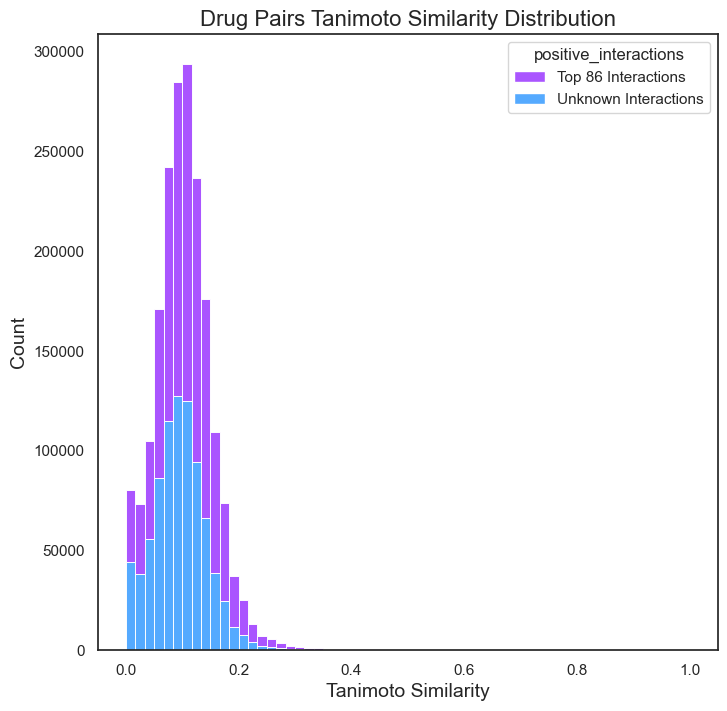

In [92]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
sns.histplot(data=morgan_df, x='tanimoto_sim', bins = 60, alpha=1, multiple="stack", hue='positive_interactions', palette='cool_r')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Tanimoto Similarity', fontsize=14)
plt.title('Drug Pairs Tanimoto Similarity Distribution', fontsize=16)
plt.show()

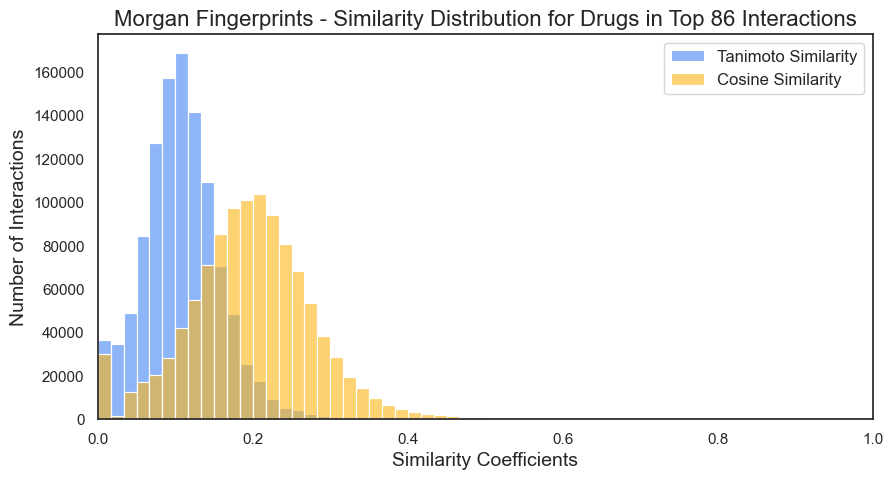

In [112]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_style('white')
sns.histplot(data=morgan_df[morgan_df['interaction_type'] != 0], x='tanimoto_sim', label='Tanimoto Similarity', bins=60, color='#4285F4', alpha=0.6)
# sns.histplot(data=morgan_df[morgan_df['interaction_type'] != 0], x='braun_blanquet_sim', label='Braun-Blanquet', bins=60, color='#FDB515', alpha=0.6)
# sns.histplot(data=morgan_df[morgan_df['interaction_type'] != 0], x='dice_sim', label='Dice', bins=60, color='#F44336', alpha=0.6)
sns.histplot(data=morgan_df[morgan_df['interaction_type'] != 0], x='cosine_sim', label='Cosine Similarity', bins=60, color='#FDB515', alpha=0.6)

plt.ylabel('Number of Interactions', fontsize=14)
plt.xlabel('Similarity Coefficients', fontsize=14)
plt.title('Morgan Fingerprints - Similarity Distribution for Drugs in Top 86 Interactions', fontsize=16)
ax.set_xlim(0, 1)
# set the ticks fontsize
# ax.tick_params(axis='both', which='major', labelsize=14)

# set the legend and adjust its position
plt.legend(loc='upper right', fontsize=12)
plt.show()

In [100]:
# RDKit Fingerprints
rdkit_df = get_fingerprints_similarities(train_df, RDKit_mapping, similarity="Cosine")
rdkit_df = rdkit_df[~rdkit_df['cosine_sim'].isnull()]
rdkit_df.head()

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_fp,d2_fp,fp_pair,cosine_sim
0,DB00006,DB00244,Bivalirudin,Mesalazine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,2,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,NC1=CC(C(O)=O)=C(O)C=C1,"[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, ...]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, ...]","[[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, ...], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, ...]]",0.317415
1,DB00006,DB00488,Bivalirudin,Altretamine,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C,"[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, ...]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, ...], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]]",0.182577
2,DB00006,DB04743,Bivalirudin,Nimesulide,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,2,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(

In [101]:
# MACC Keys
MACCS_df = get_fingerprints_similarities(train_df, MACCS_mapping, similarity="Cosine")
MACCS_df = MACCS_df[~MACCS_df['cosine_sim'].isnull()]
MACCS_df.head()

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_fp,d2_fp,fp_pair,cosine_sim
0,DB00006,DB00244,Bivalirudin,Mesalazine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,2,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,NC1=CC(C(O)=O)=C(O)C=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, ...]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, ...], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]]",0.515688
1,DB00006,DB00488,Bivalirudin,Altretamine,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,CN(C)C1=NC(=NC(=N1)N(C)C)N(C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, ...]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, ...], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...]]",0.483046
2,DB00006,DB04743,Bivalirudin,Nimesulide,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,2,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(

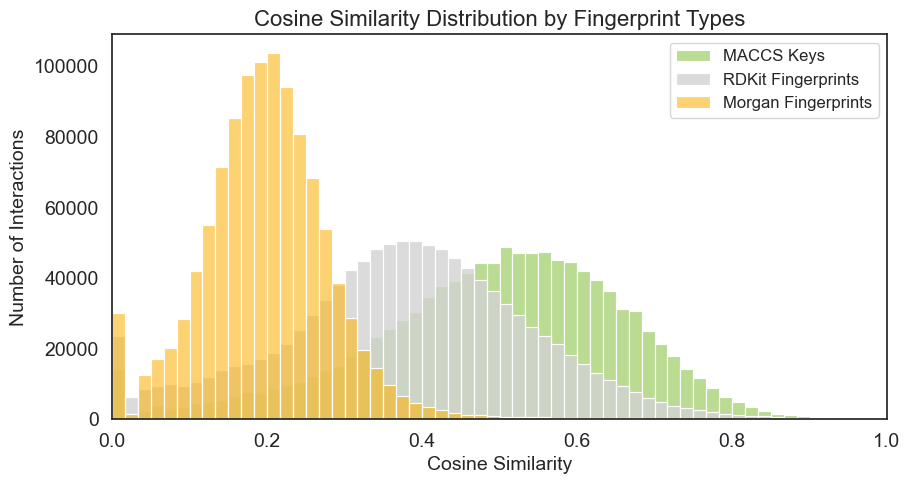

In [111]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_style('white')
# sns.histplot(data=morgan_df[morgan_df['interaction_type'] != 0], x='tanimoto_sim', label='Tanimoto Similarity', bins=60, color='#4285F4', alpha=0.6)
sns.histplot(data=MACCS_df[MACCS_df['interaction_type'] != 0], x='cosine_sim', label='MACCS Keys', bins=60, color='#8BC34A', alpha=0.6)
sns.histplot(data=rdkit_df[rdkit_df['interaction_type'] != 0], x='cosine_sim', label='RDKit Fingerprints', bins=60, color='#D3D3D3', alpha=0.8) #F44336
sns.histplot(data=morgan_df[morgan_df['interaction_type'] != 0], x='cosine_sim', label='Morgan Fingerprints', bins=60, color='#FDB515', alpha=0.6)

plt.ylabel('Number of Interactions', fontsize=14)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.title('Cosine Similarity Distribution by Fingerprint Types', fontsize=16)
ax.set_xlim(0, 1)
# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

# set the legend and adjust its position
plt.legend(loc='upper right', fontsize=12)
plt.show()

## Extract Embeddings - Using All 2036 drugs

In [132]:
# Build Basis Drug Matrix - Drugs used for Calculating Structure Similarity Embedding
print('Number of drugs in basis matrix:', len(morgan_approved_mapping.keys()))
basis_ids = list(morgan_approved_mapping.keys())
basis_smiles = [approved_smiles[x] for x in basis_ids]
basis_morgan_fingerprints = [np.array(morgan_approved_mapping[x]) for x in basis_ids]
basis_rdkit_fingerprints = [np.array(RDKit_mapping[x]) for x in basis_ids]
basis_maccs_keys = [np.array(MACCS_mapping[x]) for x in basis_ids]

# Master basis fingerprints:
basis = {"drug_ids": basis_ids,
         "smiles": basis_smiles,
         "Morgan": basis_morgan_fingerprints,
         "RDKit": basis_rdkit_fingerprints,
         "MACCS": basis_maccs_keys}

# Save basis as pickle file
with open("weights/basis_2036drugs_fingerprints.pkl", "wb") as f:
    pickle.dump(basis, f)

# basis_ids[:10]
# basis_smiles[:1]
# basis_morgan_fingerprints[:1]
# basis_rdkit_fingerprints[:1]
len(basis["Morgan"])

Number of drugs in basis matrix: 2036


2036

In [134]:
# Test pickle file
with open("weights/basis_2036drugs_fingerprints.pkl", "rb") as f:
    basis = pickle.load(f)

In [137]:
print('Number of drugs in basis:', len(basis["drug_ids"]))
list(basis["Morgan"][0][:10])

Number of drugs in basis: 2036


[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

In [138]:
def ConsineSimilarity(fp1_arr, fp2_arr):
    """Calculate Cosine Similarity from fingerprints array"""
    # Convert bits array to idx of ones value
    fp1 = set(np.nonzero(fp1_arr)[0])
    fp2 = set(np.nonzero(fp2_arr)[0])

    # Count the number of bits that are both 1 in the two fingerprints
    intersection = len(fp1 & fp2)
    # Get the L1 length from two fingerprints
    product_length = np.sqrt(len(fp1)*len(fp2))
    # Return the ratio of intersection to union
    if product_length > 0:
        return round(intersection / product_length, 7)
    else:
        return None

def TanimotoSimilarity(fp1_arr, fp2_arr):
    """Calculate Cosine Similarity from fingerprints array"""
    # Convert bits array to idx of ones value
    fp1 = set(np.nonzero(fp1_arr)[0])
    fp2 = set(np.nonzero(fp2_arr)[0])
    # Count the number of bits that are both 1 in the two fingerprints
    intersection = len(fp1 & fp2)
    # Count the Union
    union  = len(fp1) + len(fp2) - intersection
    # Return the ratio of intersection to union
    if union > 0:
        return round(intersection / union, 7)
    else:
        return None

def embedding_fingerprints(smiles, fingerprints="Morgan", similarity="Cosine"):
    """
    Input: a SMILES string representation
    Output: Embedding from fingerprints & similarity
    Extracting Embedding Vector From Fingerprints & Similarity Type
        fingerprints: Morgan, RDKit, MACCS
        Similarity: Cosine, Tanimoto
    """
    # Extract fingerprints from smiles:
    global basis

    try:
        fp1_arr = np.array(get_fingerprints(smiles, fingerprints=fingerprints))
    except:
        return None

    # Extract fingerprints basis matrix
    basis_matrix = basis[fingerprints]

    # Initialize embedding
    embedding = []

    # Calculate Similarity for drug fingerprint with the rest of the drugs in the basis
    for fp2_arr in basis_matrix:
        if similarity == "Cosine":
            drug_similarity = ConsineSimilarity(fp1_arr, fp2_arr)
        if similarity == "Tanimoto":
            drug_similarity = TanimotoSimilarity(fp1_arr, fp2_arr)
        embedding.append(drug_similarity)

    # return np.array(embedding)
    return embedding



In [12]:
### TEST BLOCK
smiles1 = basis['smiles'][0]
smiles2 = basis['smiles'][1]

## Morgan fingerprint
print('Morgan Fingerprints:')
fp1 = get_fingerprints(smiles1, fingerprints='Morgan')
fp2 = get_fingerprints(smiles2, fingerprints='Morgan')

## Manual calculation using Numpy array
fp1_arr = np.array(fp1)
fp2_arr = np.array(fp2)

print('Tanimoto Similarity:', get_similarity(fp1, fp2, metric="Tanimoto"))
print('Cosine Similarity:', get_similarity(fp1, fp2, metric="Cosine"))
print('Numpy Arr Manual Tanimoto Sim:', TanimotoSimilarity(fp1_arr, fp2_arr))
print('Numpy Arr Manual Cosine Sim:', ConsineSimilarity(fp1_arr, fp2_arr))

Morgan Fingerprints:
Tanimoto Similarity: 0.4857142857142857
Cosine Similarity: 0.6538763818184242
Numpy Arr Manual Tanimoto Sim: 0.4857
Numpy Arr Manual Cosine Sim: 0.6539


In [9]:
### TEST BLOCK
# Extract embedding of the first drug using Morgan fingerprint & Cosine similarity
smiles1 = basis['smiles'][0]
embedding_fingerprints(smiles1)[:10]

[1.0, 0.6539, 0.5421, 0.4245, 0.5793, 0.5002, 0.3691, 0.2105, 0.2546, 0.2126]

In [139]:
def create_embedding_all_drugs(drugs_smiles, fingerprint='Morgan'):
    """Create embedding for all drugs"""
    # Using Morgan fingerprints & Cosine similarity
    # fingerprints = ["Morgan", "RDKit", "MACCS"]
    similarities=["Cosine", "Tanimoto"]

    # Initialize
    # finger_embeds = {}
    # for fingerprint in fingerprints:
        # Initialize
    sim_embeds = {}
    for similarity in similarities:
        # Initialize
        drug_embeddings = {}
        for drug_id in drugs_smiles.keys():
            # Extract drug smiles for each drug_id
            drug_smi = drugs_smiles[drug_id]

            # Extract embedding array for each fingerprint & similarity type
            embedding = embedding_fingerprints(drug_smi, fingerprints=fingerprint, similarity=similarity)
            if len(embedding) > 0:
                drug_embeddings[drug_id] = embedding

        # Update embedding for each similarity
        sim_embeds[similarity] = drug_embeddings

        # Add each similarity embedding to each fingerprint type
        # finger_embeds[fingerprint] = sim_embeds

    return sim_embeds

### Morgan Embedding

In [140]:
### CREATE MORGAN FINGERPRINT EMBEDDINGS FOR ALL DRUGS IN THE DATA
all_drug_morgan_embeddings = create_embedding_all_drugs(drugs_smiles, fingerprint='Morgan')
print("Morgan Fingerprint Embedding:")
print('All Similarity Types:', all_drug_morgan_embeddings.keys())
print('Example for first drug embedding with Morgan fingerprint & Cosine similarity:')
print(all_drug_morgan_embeddings["Cosine"]['DB00006'][:10])

Morgan Fingerprint Embedding:
All Similarity Types: dict_keys(['Cosine', 'Tanimoto'])
Example for first drug embedding with Morgan fingerprint & Cosine similarity:
[1.0, 0.6538764, 0.5421063, 0.4244998, 0.579285, 0.5002252, 0.3691382, 0.2104867, 0.2545623, 0.2125788]


In [141]:
# Save embedding as json file
with open("weights/drug_morgan_embedding_2036basis.json", "w") as f:
    json.dump(all_drug_morgan_embeddings, f)

In [15]:
# # Save embedding as pickle file
# with open("weights/drug_morgan_embedding.pkl", "wb") as f:
#     pickle.dump(all_drug_morgan_embeddings, f)
#
# # Test Embedding
# with open("weights/drug_morgan_embedding.pkl", "rb") as f:
#     all_drug_morgan_embeddings = pickle.load(f)

In [15]:
print('All Similarity Types:', all_drug_morgan_embeddings.keys())
print('Example for first drug embedding with Morgan fingerprint & Cosine similarity:')
print(all_drug_morgan_embeddings["Cosine"]['DB00006'])
print('Number of Drugs:', len(all_drug_morgan_embeddings["Cosine"]))
print('Each Drug Embedding Dimension:', len(all_drug_morgan_embeddings["Cosine"]['DB00006']))
print('Number of Drugs:', len(all_drug_morgan_embeddings["Tanimoto"]))
print('Each Drug Embedding Dimension:', len(all_drug_morgan_embeddings["Tanimoto"]['DB00006']))

All Similarity Types: dict_keys(['Cosine', 'Tanimoto'])
Example for first drug embedding with Morgan fingerprint & Cosine similarity:
[1.     0.6539 0.5421 ... 0.2094 0.3003 0.229 ]
Number of Drugs: 2567
Each Drug Embedding Dimension: 2036
Number of Drugs: 2567
Each Drug Embedding Dimension: 2036


### RDKit Embedding

In [11]:
### CREATE MORGAN FINGERPRINT EMBEDDINGS FOR ALL DRUGS IN THE DATA
all_drug_rdkit_embeddings = create_embedding_all_drugs(drugs_smiles, fingerprint='RDKit')
print("RDKit Fingerprint Embedding:")
print('All Similarity Types:', all_drug_rdkit_embeddings.keys())
print('Example for first drug embedding with RDKit fingerprint & Cosine similarity:')
print(all_drug_rdkit_embeddings["Cosine"]['DB00006'])

[17:12:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:12:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:14:37] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:20:13] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[17:20:13] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
[17:24:27] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:24:30] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:26:21] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:31:58] SMILES Parse Error: syntax error while parsing

RDKit Fingerprint Embedding:
All Similarity Types: dict_keys(['Cosine', 'Tanimoto'])
Example for first drug embedding with RDKit fingerprint & Cosine similarity:
[1.0 0.7826 0.7436 ... 0.6616 0.4799 0.5642]


In [12]:
# Save embedding as json file
with open("weights/drug_rdkit_embedding_2036basis.json", "w") as f:
    json.dump(all_drug_rdkit_embeddings, f)

# # Save embedding as json file
# with open("weights/drug_rdkit_embedding.pkl", "wb") as f:
#     pickle.dump(all_drug_rdkit_embeddings, f)

### MACCS Keys

In [9]:
### CREATE MACCS KEYS EMBEDDINGS FOR ALL DRUGS IN THE DATA
all_drug_maccs_embeddings = create_embedding_all_drugs(drugs_smiles, fingerprint='MACCS')
print("MACCS Keys Embedding:")
print('All Similarity Types:', all_drug_maccs_embeddings.keys())
print('Example for first drug embedding with MACCS Keys & Cosine similarity:')
print(all_drug_maccs_embeddings["Cosine"]['DB00006'])

[17:03:34] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:03:34] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:03:51] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:04:41] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[17:04:41] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
[17:05:18] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:05:18] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:05:34] Explicit valence for atom # 0 N, 4, is greater than permitted
[17:06:23] SMILES Parse Error: syntax error while parsing

MACCS Keys Embedding:
All Similarity Types: dict_keys(['Cosine', 'Tanimoto'])
Example for first drug embedding with MACCS Keys & Cosine similarity:
[1.0 0.9587 0.8921 ... 0.7561 0.6181 0.6571]


In [10]:
# Save embedding as json file
with open("weights/drug_maccs_embedding_2036basis.json", "w") as f:
    json.dump(all_drug_maccs_embeddings, f)

# # Save embedding as json file
# with open("weights/drug_maccs_embedding.pkl", "wb") as f:
#     pickle.dump(all_drug_maccs_embeddings, f)

### All Fingerprint Together

In [16]:
def create_embedding_all_drugs(drugs_smiles):
    """Create embedding for all drugs"""
    # Using Morgan fingerprints & Cosine similarity
    fingerprints = ["Morgan", "RDKit", "MACCS"]
    similarities=["Cosine", "Tanimoto"]

    # Initialize
    finger_embeds = {}
    for fingerprint in fingerprints:
        # Initialize
        sim_embeds = {}
        for similarity in similarities:
            # Initialize
            drug_embeddings = {}
            for drug_id in drugs_smiles.keys():
                # Extract drug smiles for each drug_id
                drug_smi = drugs_smiles[drug_id]

                # Extract embedding array for each fingerprint & similarity type
                embedding = embedding_fingerprints(drug_smi, fingerprints=fingerprint, similarity=similarity)
                if len(embedding) > 0:
                    drug_embeddings[drug_id] = embedding

            # Update embedding for each similarity
            sim_embeds[similarity] = drug_embeddings

        # Add each similarity embedding to each fingerprint type
        finger_embeds[fingerprint] = sim_embeds

    return finger_embeds

In [17]:
### CREATE DIFFERENT EMBEDDINGS FOR ALL DRUGS IN THE DATA
all_drug_embeddings = create_embedding_all_drugs(drugs_smiles)
print('All Fingerprint Types:', all_drug_embeddings.keys())
print('All Similarity Types', all_drug_embeddings["Morgan"].keys())
print('Example for first drug embedding with Morgan fingerprint & Cosine similarity:')
print(all_drug_embeddings["Morgan"]["Cosine"]['DB00006'])

[22:19:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:19:15] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:19:37] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:20:41] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[22:20:41] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'
[22:21:27] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:21:27] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:21:48] Explicit valence for atom # 0 N, 4, is greater than permitted
[22:22:51] SMILES Parse Error: syntax error while parsing

All Fingerprint Types: dict_keys(['Morgan', 'RDKit', 'MACCS'])
All Similarity Types dict_keys(['Cosine', 'Tanimoto'])
Example for first drug embedding with Morgan fingerprint & Cosine similarity:
[1.     0.6539 0.5421 ... 0.2094 0.3003 0.229 ]


In [25]:
all_drug_embeddings["Morgan"]["Cosine"]

{'DB00006': array([1.    , 0.6539, 0.5421, ..., 0.2094, 0.3003, 0.229 ]),
 'DB00007': array([0.6539, 1.    , 0.7644, ..., 0.2806, 0.3222, 0.2394]),
 'DB00014': array([0.5421, 0.7644, 1.    , ..., 0.2681, 0.2961, 0.2408]),
 'DB00027': array([0.4245, 0.5045, 0.4706, ..., 0.2154, 0.3439, 0.2225]),
 'DB00035': array([0.5793, 0.5435, 0.4713, ..., 0.2579, 0.2489, 0.2397]),
 'DB00067': array([0.5002, 0.4459, 0.5113, ..., 0.2538, 0.245 , 0.2228]),
 'DB00080': array([0.3691, 0.4204, 0.393 , ..., 0.2927, 0.2617, 0.2176]),
 'DB00091': array([0.2105, 0.2201, 0.2213, ..., 0.2819, 0.1356, 0.2298]),
 'DB00115': array([0.2546, 0.2174, 0.1911, ..., 0.2227, 0.1923, 0.207 ]),
 'DB00118': array([0.2126, 0.2105, 0.2138, ..., 0.2191, 0.1712, 0.2263]),
 'DB00120': array([0.4412, 0.3121, 0.2783, ..., 0.1599, 0.2978, 0.2477]),
 'DB00122': array([0.0853, 0.1409, 0.1346, ..., 0.1083, 0.11  , 0.1118]),
 'DB00126': array([0.1577, 0.2147, 0.2052, ..., 0.2   , 0.1524, 0.1807]),
 'DB00127': array([0.164 , 0.1624, 0.1

In [18]:
# Save embedding as json file
with open("weights/drug_fingerprints_embedding.pkl", "wb") as f:
    pickle.dump(all_drug_embeddings, f)

In [20]:
# Test pickle file
with open("weights/drug_fingerprints_embedding.pkl", "rb") as f:
    test_drug_embeddings = pickle.load(f)

In [24]:
test_drug_embeddings["Morgan"]["Cosine"]['DB00006']

array([1.    , 0.6539, 0.5421, ..., 0.2094, 0.3003, 0.229 ])

## Extract Embeddings - Using Top 300 Drugs

In [144]:
# Find the top 300 approved drugs that have the most positive interactions
# d1_count = train_df['d1'].value_counts().nlargest(300).index
positive_ddis_df = train_df[train_df['interaction_type'] != 0]
interaction_counts = positive_ddis_df['d1'].value_counts() + positive_ddis_df['d2'].value_counts()
top_300_drugs = sorted(interaction_counts.nlargest(300).index)
top_300_drug_smiles = {drug: drugs_smiles[drug] for drug in top_300_drugs}
print("Number of Top 300 Drugs:", len(top_300_drug_smiles.keys()))
print("Example of Top 300 Drugs:", list(top_300_drug_smiles.keys())[:10])
print("Example of first Smiles:", list(top_300_drug_smiles.values())[0])

Number of Top 300 Drugs: 300
Example of Top 300 Drugs: ['DB00091', 'DB00176', 'DB00181', 'DB00182', 'DB00186', 'DB00188', 'DB00193', 'DB00196', 'DB00206', 'DB00208']
Example of first Smiles: CC[C@@H]1NC(=O)[C@H]([C@H](O)[C@H](C)C\C=C\C)N(C)C(=O)[C@H](C(C)C)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H](NC(=O)[C@H](CC(C)C)N(C)C(=O)CN(C)C1=O)C(C)C


In [145]:
# Build Basis Drug Matrix - Drugs used for Calculating Structure Similarity Embedding
print('Number of drugs in basis matrix:', len(top_300_drug_smiles.keys()))
basis_ids = list(top_300_drug_smiles.keys())
basis_smiles = list(top_300_drug_smiles.values())
basis_morgan_fingerprints = [np.array(morgan_mapping[x]) for x in basis_ids]
basis_rdkit_fingerprints = [np.array(RDKit_mapping[x]) for x in basis_ids]
basis_maccs_keys = [np.array(MACCS_mapping[x]) for x in basis_ids]

# Master basis fingerprints:
basis = {"drug_ids": basis_ids,
         "smiles": basis_smiles,
         "Morgan": basis_morgan_fingerprints,
         "RDKit": basis_rdkit_fingerprints,
         "MACCS": basis_maccs_keys}

# Save basis as pickle file
with open("weights/basis_300drugs_fingerprints.pkl", "wb") as f:
    pickle.dump(basis, f)

# basis_ids[:10]
# basis_smiles[:1]
# basis_morgan_fingerprints[:1]
# basis_rdkit_fingerprints[:1]
len(basis["Morgan"])

Number of drugs in basis matrix: 300


300

In [52]:
# Test pickle file
with open("weights/basis_300drugs_fingerprints.pkl", "rb") as f:
    basis = pickle.load(f)

print('Number of drugs in basis:', len(basis["drug_ids"]))
list(basis["Morgan"][0])[:10]

Number of drugs in basis: 300


[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]

### Morgan Embedding

In [146]:
### CREATE MORGAN FINGERPRINT EMBEDDINGS FOR ALL DRUGS IN THE DATA
all_drug_morgan_embeddings = create_embedding_all_drugs(drugs_smiles, fingerprint='Morgan')
print("Morgan Fingerprint Embedding:")
print('All Similarity Types:', all_drug_morgan_embeddings.keys())
print("First 10 drugs with Morgan fingerprint & Cosine similarity:", list(all_drug_morgan_embeddings["Cosine"].keys())[:10])
print('Example for the first drug embedding with Morgan fingerprint & Cosine similarity:')
print(all_drug_morgan_embeddings["Cosine"]['DB00006'][:10])
print('Embedding Dimension:', len(list(all_drug_morgan_embeddings["Cosine"].values())[0]))

Morgan Fingerprint Embedding:
All Similarity Types: dict_keys(['Cosine', 'Tanimoto'])
First 10 drugs with Morgan fingerprint & Cosine similarity: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']
Example for the first drug embedding with Morgan fingerprint & Cosine similarity:
[0.2104867, 0.1713737, 0.2465147, 0.3842851, 0.157779, 0.3839941, 0.2208905, 0.1520843, 0.2031308, 0.2027791]
Embedding Dimension: 300


In [147]:
# Save embedding as json file
with open("weights/drug_morgan_embedding_300basis.json", "w") as f:
    json.dump(all_drug_morgan_embeddings, f)

In [148]:
# Save as text file using similar format of word2vec embedding
def export_drug2vec(all_drug_embeddings, similarity="Tanimoto",file_name="weights/drug2vec_300basis_morgan_tanimoto.txt"):
    with open(file_name, "w") as f:
        # First Row
        vocab_size = str(len(all_drug_embeddings[similarity].keys()))
        embed_len = str(len(list(all_drug_embeddings[similarity].values())[0]))
        embed_shape = vocab_size + ' ' + embed_len + '\n'
        f.write(embed_shape)

        # Embedding Rows
        for drug in all_drug_embeddings[similarity].keys():
            similarity_list = list(all_drug_embeddings[similarity][drug])
            similarity_str = ' '.join([str(x) for x in similarity_list])
            drug_embed = drug + ' ' + similarity_str + '\n'
            f.write(drug_embed)

In [149]:
# Export Morgan Similarity Embedding with Tanimoto Similarity to text file
export_drug2vec(all_drug_morgan_embeddings, similarity="Tanimoto",file_name="weights/drug2vec_300basis_morgan_tanimoto.txt")

# Export Morgan Similarity Embedding with Cosine Similarity to text file
export_drug2vec(all_drug_morgan_embeddings, similarity="Cosine",file_name="weights/drug2vec_300basis_morgan_cosine.txt")

In [151]:
## Test gensim Drug2Vec Embedding
drug2vec_model = gensim.models.KeyedVectors.load_word2vec_format(fname="weights/drug2vec_300basis_morgan_tanimoto.txt", binary=False)

In [152]:
list(drug2vec_model['DB00006'][:10])

[0.2104867,
 0.1713737,
 0.2465147,
 0.3842851,
 0.157779,
 0.3839941,
 0.2208905,
 0.1520843,
 0.2031308,
 0.2027791]

In [153]:
# len(drug2vec_model.vocab)
len(drug2vec_model.index_to_key)

2563

In [154]:
drug2vec_model.index_to_key[:10]

['DB00006',
 'DB00007',
 'DB00014',
 'DB00027',
 'DB00035',
 'DB00067',
 'DB00080',
 'DB00091',
 'DB00115',
 'DB00118']

In [128]:
#@title Embedding Matrix Creation
EMBEDDING_DIM = 300      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(drug2vec_model.index_to_key) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(drug2vec_model.index_to_key):
    embedding_vector = drug2vec_model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

In [129]:
embedding_matrix.shape

(2564, 300)

In [130]:
embedding_matrix[:5, :5]

array([[0.2104867 , 0.1713737 , 0.24651469, 0.38428509, 0.15777899],
       [0.2200543 , 0.185164  , 0.2065933 , 0.29105291, 0.2031498 ],
       [0.2213359 , 0.1916745 , 0.19740669, 0.27811071, 0.1791843 ],
       [0.18990751, 0.1167748 , 0.2132007 , 0.28239119, 0.1971041 ],
       [0.2325736 , 0.17939021, 0.2183468 , 0.28394911, 0.19819149]])

### RDKit Embedding

In [155]:
### CREATE RDKIT FINGERPRINT EMBEDDINGS FOR ALL DRUGS IN THE DATA
all_drug_rdkit_embeddings = create_embedding_all_drugs(drugs_smiles, fingerprint='RDKit')
print("RDKit Fingerprint Embedding:")
print('All Similarity Types:', all_drug_rdkit_embeddings.keys())
print("First 10 drugs with RDKit fingerprint & Cosine similarity:", list(all_drug_rdkit_embeddings["Cosine"].keys())[:10])
print('Example for first drug embedding with RDKit fingerprint & Cosine similarity:')
print(list(all_drug_rdkit_embeddings["Cosine"].values())[0][:10])
print('Embedding Dimension:', len(list(all_drug_rdkit_embeddings["Cosine"].values())[0]))

RDKit Fingerprint Embedding:
All Similarity Types: dict_keys(['Cosine', 'Tanimoto'])
First 10 drugs with RDKit fingerprint & Cosine similarity: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']
Example for first drug embedding with RDKit fingerprint & Cosine similarity:
[0.6846379, 0.390821, 0.4010189, 0.3589633, 0.4648334, 0.5965905, 0.4840373, 0.3994174, 0.6054094, 0.3993195]
Embedding Dimension: 300


In [156]:
# Save embedding as json file
with open("weights/drug_rdkit_embedding_300basis.json", "w") as f:
    json.dump(all_drug_rdkit_embeddings, f)

In [157]:
# Export RDKit Similarity Embedding with Tanimoto Similarity to text file
export_drug2vec(all_drug_rdkit_embeddings, similarity="Tanimoto",file_name="weights/drug2vec_300basis_rdkit_tanimoto.txt")

In [158]:
# Export RDKit Similarity Embedding with Cosine Similarity to text file
export_drug2vec(all_drug_rdkit_embeddings, similarity="Cosine",file_name="weights/drug2vec_300basis_rdkit_cosine.txt")

### MACCS Keys

In [159]:
### CREATE MACCS KEYS FINGERPRINT EMBEDDINGS FOR ALL DRUGS IN THE DATA
all_drug_maccs_embeddings = create_embedding_all_drugs(drugs_smiles, fingerprint='MACCS')
print("MACCS Keys Fingerprint Embedding:")
print('All Similarity Types:', all_drug_maccs_embeddings .keys())
print("First 10 drugs with MACCS Keys fingerprint & Cosine similarity:", list(all_drug_maccs_embeddings ["Cosine"].keys())[:10])
print('Example for first drug embedding with MACCS Keys fingerprint & Cosine similarity:')
print(list(all_drug_maccs_embeddings["Cosine"].values())[0][:10])
print('Embedding Dimension:', len(list(all_drug_maccs_embeddings["Cosine"].values())[0]))

MACCS Keys Fingerprint Embedding:
All Similarity Types: dict_keys(['Cosine', 'Tanimoto'])
First 10 drugs with MACCS Keys fingerprint & Cosine similarity: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']
Example for first drug embedding with MACCS Keys fingerprint & Cosine similarity:
[0.7897065, 0.5463032, 0.515688, 0.4309458, 0.5717261, 0.6799338, 0.6454972, 0.5879747, 0.7376237, 0.5041184]
Embedding Dimension: 300


In [160]:
# Save embedding as json file
with open("weights/drug_maccs_embedding_300basis.json", "w") as f:
    json.dump(all_drug_maccs_embeddings, f)

In [161]:
# Export MACCS Keys Similarity Embedding with Tanimoto Similarity to text file
export_drug2vec(all_drug_maccs_embeddings, similarity="Tanimoto",file_name="weights/drug2vec_300basis_maccs_tanimoto.txt")

In [162]:
# Export RDKit Similarity Embedding with Cosine Similarity to text file
export_drug2vec(all_drug_maccs_embeddings, similarity="Cosine",file_name="weights/drug2vec_300basis_maccs_cosine.txt")

## Clustering Drugs to 100 Groups / Cluster to Build Drug Basis
### Clustering

In [7]:
# Read all drug fingerprints info
with open("weights/basis_2036drugs_fingerprints.pkl", "rb") as f:
    all_drug_fingerprints = pickle.load(f)

In [8]:
all_drugs_ids = all_drug_fingerprints["drug_ids"]
all_drugs_morgan_fp = np.stack(all_drug_fingerprints["Morgan"])
all_drugs_rdkit_fp = np.stack(all_drug_fingerprints["RDKit"])
all_drugs_maccs_fp = np.stack(all_drug_fingerprints["MACCS"])
print('Shape of binary encoding fingerprints:', all_drugs_morgan_fp.shape)
all_drugs_morgan_fp[:5, :5]

Shape of binary encoding fingerprints: (2036, 1024)


array([[0, 1, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1]])

## Fraction of The Total Variance Explained by The First k Principal Components:

| k Value | Total Explained Variance |
|       1 |                   0.0384 |
|       5 |                   0.1268 |
|      10 |                   0.1891 |
|      20 |                   0.2744 |
|      30 |                   0.3371 |
|      40 |                   0.3863 |
|      50 |                   0.4278 |
|     100 |                   0.5735 |
|     200 |                   0.7338 |
|     300 |                   0.8270 |
|     400 |                   0.8879 |
|     500 |                   0.9289 |
|     750 |                   0.9828 |
|    1000 |                   0.9995 |
|    1500 |                   1.0000 |
|    2000 |                   1.0000 |
|    2030 |                   1.0000 |

## Plotintg of Fraction of Total Variance vs k:



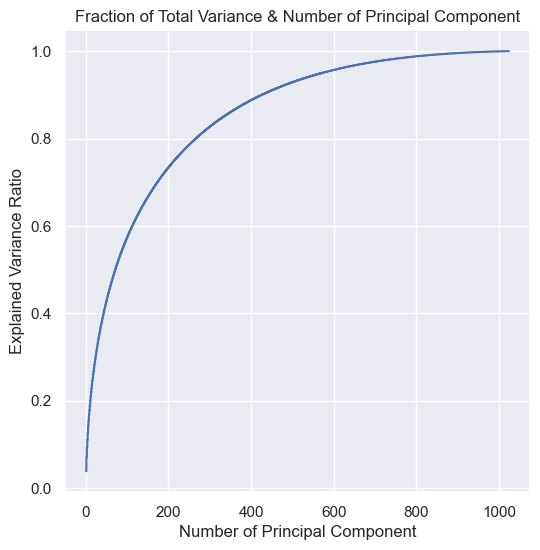

In [20]:
def pca_analysis(X_train=all_drugs_morgan_fp):
    ## PART 1. Do a principal components analysis on the data
    pca = PCA(n_components=None)
    X_train_pca = pca.fit_transform(X_train)
    # Get the explained variance ratio for all pricipal components
    expl_var_ratio = pca.explained_variance_ratio_

    ## PART 2. Print what fraction of the total variance in the training data
    # is explained by the first k principal components
    k_values = [1, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 750, 1000, 1500, 2000, 2030]
    total_vars = [expl_var_ratio[:k].sum() for k in k_values]
    print('## Fraction of The Total Variance Explained by The First k Principal Components:')
    print('\n| k Value | Total Explained Variance |')
    for i in range(len(k_values)):
        print(f'| {k_values[i]:>7} | {total_vars[i]:>24.4f} |')

    ## PART 3. Show a lineplot of fraction of total variance vs. number of principal components
    print('\n## Plotintg of Fraction of Total Variance vs k:\n')
    x_axis = range(1,len(expl_var_ratio)+1)
    plt.subplots(figsize=(6, 6))
    plt.step(x_axis, np.cumsum(expl_var_ratio), where='mid')
    plt.title('Fraction of Total Variance & Number of Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Number of Principal Component')

pca_analysis(X_train=all_drugs_morgan_fp)

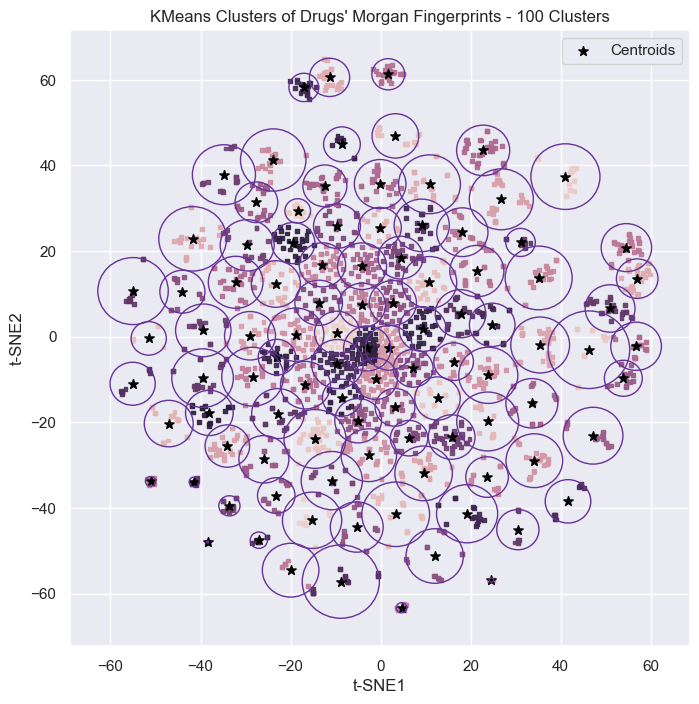

In [78]:
## KMEANS Clustering to Cluster the Drugs to 100 Clusters
def cluster_with_KMeans(X_train=all_drugs_morgan_fp, n_clusters=100):
    ## PART 1. Fit a k-means cluster model with 500 clusters over the 2d projected data
    # pca = PCA(n_components=2)
    tsne = TSNE(n_components=2)
    X_train_tsne = tsne.fit_transform(X_train)

    km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X_train_tsne)

    # Calculate the distance between the centroids and the furthest point in a cluster
    centroids = km.cluster_centers_   # Centroids position
    # Get the max distance between a centroid to other points in the same cluster
    distances = [np.linalg.norm(X_train_tsne[y_km==x]-centroids[x,:], axis=1).max()
                 for x in range(n_clusters)]

    # Mark the centroid and plot a circle that goes through the cluster's example
    # that is most distant from the centroid.
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.scatter(X_train_tsne[:,0], X_train_tsne[:, 1],
                marker='s', s=8, alpha=0.9, c=y_km,
                # cmap="RdYlGn"
                cmap=sns.cubehelix_palette(as_cmap=True)
                )

    # Plot centroids
    plt.scatter(centroids[:,0],centroids[:,1],
                c='black', marker='*', s=50, label='Centroids')

    # Plot circles around the centroids
    for x in range(n_clusters):
        ax.add_patch(plt.Circle(tuple(centroids[x]), distances[x], color="#663399", fill=False))
    plt.title(f'KMeans Clusters of Drugs\' Morgan Fingerprints - {n_clusters} Clusters')
    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.legend()
    plt.show()

cluster_with_KMeans(X_train=all_drugs_morgan_fp, n_clusters=100)

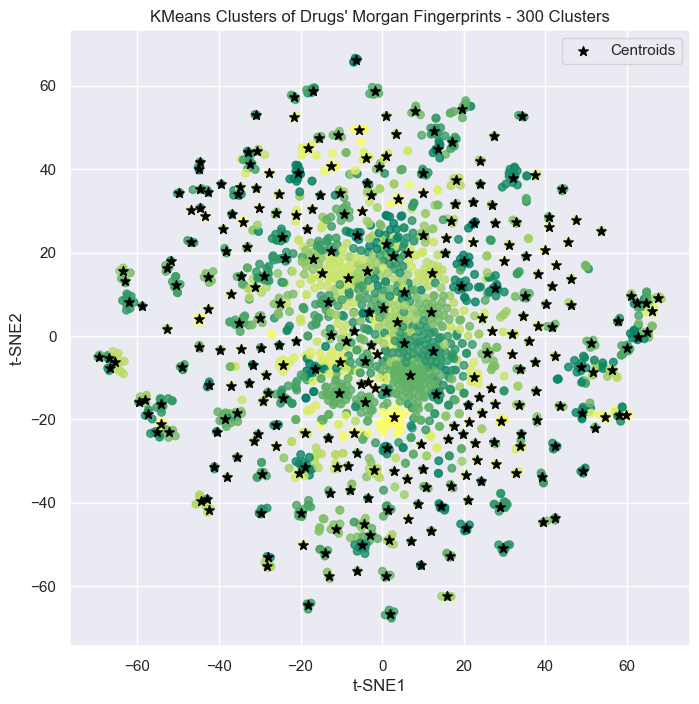

In [24]:
# Extract the fingerprints of nearest neighbor to the centroid of the 100 clusters to form the 100 basis
def Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_morgan_fp, n_clusters=300):
    ## PART 1. Fit a k-means cluster model with n_clusters clusters
    km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, max_iter=300, tol=1e-04, random_state=0)
    km_group = km.fit_predict(X_train)

    # Calculate the distance between the centroids and the furthest point in a cluster
    centroids = km.cluster_centers_   # Centroids position
    # Convert Centroids' coordinates to binary encoding
    adj_centroids = (centroids >= 0.5).astype('int')
    # Get the min distance between a centroid to other points in the same cluster
    # min_distance = [np.linalg.norm(X_train[y_km==x]-centroids[x,:], axis=1).min()
    #              for x in range(n_clusters)]

    # Add centroids to training data for plotting
    X_train_combined = np.concatenate((X_train, adj_centroids), axis=0)

    # Use tsne to reduce to 2 dimensions for plotting
    tsne = TSNE(n_components=2, random_state=0)
    X_train_combined_2d = tsne.fit_transform(X_train_combined)

    # Split the 2 dim data
    X_train_2d = X_train_combined_2d[:len(X_train)]
    adj_centroids_2d = X_train_combined_2d[len(X_train):]

    # Plot the clusters and the centroids on a scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=km_group, s=30, cmap="summer", alpha=0.8)
    plt.scatter(adj_centroids_2d[:, 0], adj_centroids_2d[:, 1], c='black', s=50, marker='*', label="Centroids")

    plt.title(f'KMeans Clusters of Drugs\' Morgan Fingerprints - {n_clusters} Clusters')
    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.legend()
    plt.show()

    return adj_centroids

morgan_100_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_morgan_fp, n_clusters=300)

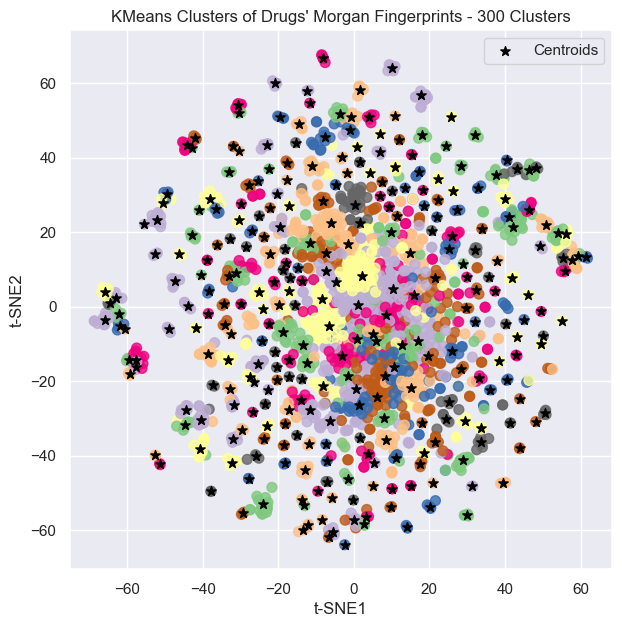

In [31]:
# Extract the fingerprints of nearest neighbor to the centroid of the 100 clusters to form the 100 basis
def Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_morgan_fp, n_clusters=300):
    ## PART 1. Fit a k-means cluster model with n_clusters clusters
    km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, max_iter=300, tol=1e-04, random_state=0)
    km_group = km.fit_predict(X_train)

    # Calculate the distance between the centroids and the furthest point in a cluster
    centroids = km.cluster_centers_   # Centroids position
    # Convert Centroids' coordinates to binary encoding
    adj_centroids = (centroids >= 0.5).astype('int')
    # Get the min distance between a centroid to other points in the same cluster
    # min_distance = [np.linalg.norm(X_train[y_km==x]-centroids[x,:], axis=1).min()
    #              for x in range(n_clusters)]

    # Add centroids to training data for plotting
    X_train_combined = np.concatenate((X_train, adj_centroids), axis=0)

    # Use tsne to reduce to 2 dimensions for plotting
    tsne = TSNE(n_components=2, random_state=0)
    X_train_combined_2d = tsne.fit_transform(X_train_combined)

    # Split the 2 dim data
    X_train_2d = X_train_combined_2d[:len(X_train)]
    adj_centroids_2d = X_train_combined_2d[len(X_train):]

    # Plot the clusters and the centroids on a scatter plot
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=km_group, s=50, cmap="Accent", alpha=0.8)
    plt.scatter(adj_centroids_2d[:, 0], adj_centroids_2d[:, 1], c='black', s=50, marker='*', label="Centroids")

    plt.title(f'KMeans Clusters of Drugs\' Morgan Fingerprints - {n_clusters} Clusters')
    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.legend()
    plt.show()

    return adj_centroids

morgan_100_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_morgan_fp, n_clusters=300)

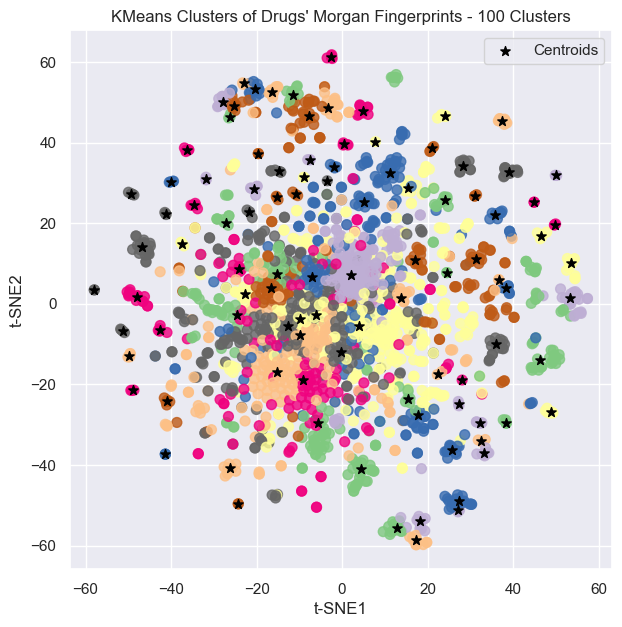

In [32]:
# Extract the fingerprints of nearest neighbor to the centroid of the 100 clusters to form the 100 basis
def Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_morgan_fp, n_clusters=300):
    ## PART 1. Fit a k-means cluster model with n_clusters clusters
    km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, max_iter=300, tol=1e-04, random_state=0)
    km_group = km.fit_predict(X_train)

    # Calculate the distance between the centroids and the furthest point in a cluster
    centroids = km.cluster_centers_   # Centroids position
    # Convert Centroids' coordinates to binary encoding
    adj_centroids = (centroids >= 0.5).astype('int')
    # Get the min distance between a centroid to other points in the same cluster
    # min_distance = [np.linalg.norm(X_train[y_km==x]-centroids[x,:], axis=1).min()
    #              for x in range(n_clusters)]

    # Add centroids to training data for plotting
    X_train_combined = np.concatenate((X_train, adj_centroids), axis=0)

    # Use tsne to reduce to 2 dimensions for plotting
    tsne = TSNE(n_components=2, random_state=0)
    X_train_combined_2d = tsne.fit_transform(X_train_combined)

    # Split the 2 dim data
    X_train_2d = X_train_combined_2d[:len(X_train)]
    adj_centroids_2d = X_train_combined_2d[len(X_train):]

    # Plot the clusters and the centroids on a scatter plot
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=km_group, s=50, cmap="Accent", alpha=0.8)
    plt.scatter(adj_centroids_2d[:, 0], adj_centroids_2d[:, 1], c='black', s=50, marker='*', label="Centroids")

    plt.title(f'KMeans Clusters of Drugs\' Morgan Fingerprints - {n_clusters} Clusters')
    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.legend()
    plt.show()

    return adj_centroids

morgan_100_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_morgan_fp, n_clusters=100)

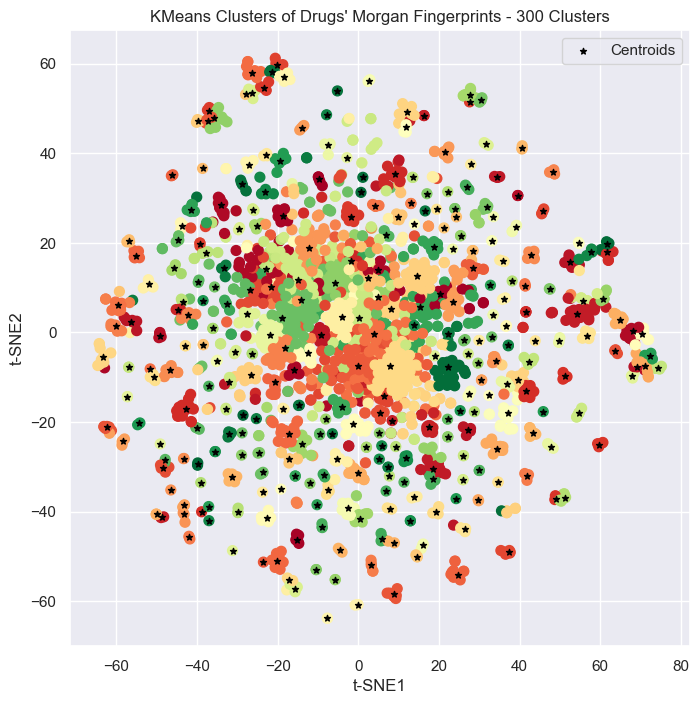

In [11]:
# Extract the fingerprints of nearest neighbor to the centroid of the 100 clusters to form the 100 basis
def Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_morgan_fp, n_clusters=300):
    ## PART 1. Fit a k-means cluster model with n_clusters clusters
    km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, max_iter=300, tol=1e-04, random_state=0)
    km_group = km.fit_predict(X_train)

    # Calculate the distance between the centroids and the furthest point in a cluster
    centroids = km.cluster_centers_   # Centroids position
    # Convert Centroids' coordinates to binary encoding
    adj_centroids = (centroids >= 0.5).astype('int')
    # Get the min distance between a centroid to other points in the same cluster
    # min_distance = [np.linalg.norm(X_train[y_km==x]-centroids[x,:], axis=1).min()
    #              for x in range(n_clusters)]

    # Add centroids to training data for plotting
    X_train_combined = np.concatenate((X_train, adj_centroids), axis=0)

    # Use tsne to reduce to 2 dimensions for plotting
    tsne = TSNE(n_components=2, random_state=0)
    X_train_combined_2d = tsne.fit_transform(X_train_combined)

    # Split the 2 dim data
    X_train_2d = X_train_combined_2d[:len(X_train)]
    adj_centroids_2d = X_train_combined_2d[len(X_train):]

    # Plot the clusters and the centroids on a scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=km_group, s=50, cmap="RdYlGn")
    plt.scatter(adj_centroids_2d[:, 0], adj_centroids_2d[:, 1], c='black', s=20, marker='*', label="Centroids")

    plt.title(f'KMeans Clusters of Drugs\' Morgan Fingerprints - {n_clusters} Clusters')
    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.legend()
    plt.show()

    return adj_centroids

morgan_300_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_morgan_fp, n_clusters=300)

In [52]:
morgan_100_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_morgan_fp, n_clusters=100)
rdkit_100_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_rdkit_fp, n_clusters=100)
maccs_100_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_maccs_fp, n_clusters=100)

print('Centroids Morgan Fingerprints Shape', morgan_100_centroids.shape)
print('Example Centroids Morgan Fingerprints',morgan_100_centroids[:5,:5])
print('Centroids RDKit Fingerprints Shape', rdkit_100_centroids.shape)
print('Example Centroids RDKit Fingerprints',rdkit_100_centroids[:5,:5])
print('Centroids MACCS Keys Fingerprints Shape', maccs_100_centroids.shape)
print('Example Centroids MACCS Keys Fingerprints',maccs_100_centroids[:5,:5])

Centroids Morgan Fingerprints Shape (100, 1024)
Example Centroids Morgan Fingerprints [[0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Centroids RDKit Fingerprints Shape (100, 2048)
Example Centroids RDKit Fingerprints [[1 1 0 1 0]
 [0 0 0 0 0]
 [1 0 1 0 0]
 [0 0 0 0 0]
 [1 1 1 1 1]]
Centroids MACCS Keys Fingerprints Shape (100, 167)
Example Centroids MACCS Keys Fingerprints [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [9]:
## 300 clusters
morgan_300_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_morgan_fp, n_clusters=300)
rdkit_300_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_rdkit_fp, n_clusters=300)
maccs_300_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_maccs_fp, n_clusters=300)

print('Centroids Morgan Fingerprints Shape', morgan_300_centroids.shape)
print('Example Centroids Morgan Fingerprints',morgan_300_centroids[:5,:5])
print('Centroids RDKit Fingerprints Shape', rdkit_300_centroids.shape)
print('Example Centroids RDKit Fingerprints',rdkit_300_centroids[:5,:5])
print('Centroids MACCS Keys Fingerprints Shape', maccs_300_centroids.shape)
print('Example Centroids MACCS Keys Fingerprints',maccs_300_centroids[:5,:5])

Centroids Morgan Fingerprints Shape (300, 1024)
Example Centroids Morgan Fingerprints [[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 0]]
Centroids RDKit Fingerprints Shape (300, 2048)
Example Centroids RDKit Fingerprints [[0 0 0 0 0]
 [1 0 1 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]]
Centroids MACCS Keys Fingerprints Shape (300, 167)
Example Centroids MACCS Keys Fingerprints [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [22]:
## 768 clusters
morgan_768_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_morgan_fp, n_clusters=768)
rdkit_768_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_rdkit_fp, n_clusters=768)
maccs_768_centroids = Get_KMeans_Centroids_Fingerprints(X_train=all_drugs_maccs_fp, n_clusters=768)

print('Centroids Morgan Fingerprints Shape', morgan_768_centroids.shape)
print('Example Centroids Morgan Fingerprints',morgan_768_centroids[:5,:5])
print('Centroids RDKit Fingerprints Shape', rdkit_768_centroids.shape)
print('Example Centroids RDKit Fingerprints',rdkit_768_centroids[:5,:5])
print('Centroids MACCS Keys Fingerprints Shape', maccs_768_centroids.shape)
print('Example Centroids MACCS Keys Fingerprints',maccs_768_centroids[:5,:5])

Centroids Morgan Fingerprints Shape (768, 1024)
Example Centroids Morgan Fingerprints [[0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Centroids RDKit Fingerprints Shape (768, 2048)
Example Centroids RDKit Fingerprints [[0 0 0 0 0]
 [1 1 1 1 0]
 [0 0 0 0 0]
 [1 1 0 0 1]
 [1 1 0 1 0]]
Centroids MACCS Keys Fingerprints Shape (768, 167)
Example Centroids MACCS Keys Fingerprints [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [57]:
# Master basis fingerprints from 100 centroids:
basis_100centroids = {
         "Morgan": morgan_100_centroids,
         "RDKit": rdkit_100_centroids,
         "MACCS": maccs_100_centroids
}

# Save basis as pickle file
with open("weights/basis_100centroids_fingerprints.pkl", "wb") as f:
    pickle.dump(basis_100centroids, f)

In [11]:
# Master basis fingerprints from 300 centroids:
basis_300centroids = {
    "Morgan": morgan_300_centroids,
    "RDKit": rdkit_300_centroids,
    "MACCS": maccs_300_centroids
}

# Save basis as pickle file
with open("weights/basis_300centroids_fingerprints.pkl", "wb") as f:
    pickle.dump(basis_300centroids, f)

In [23]:
# Master basis fingerprints from 768 centroids:
basis_768_centroids = {
    "Morgan": morgan_768_centroids,
    "RDKit": rdkit_768_centroids,
    "MACCS": maccs_768_centroids
}

# Save basis as pickle file
with open("weights/basis_768_centroids_fingerprints.pkl", "wb") as f:
    pickle.dump(basis_768_centroids, f)

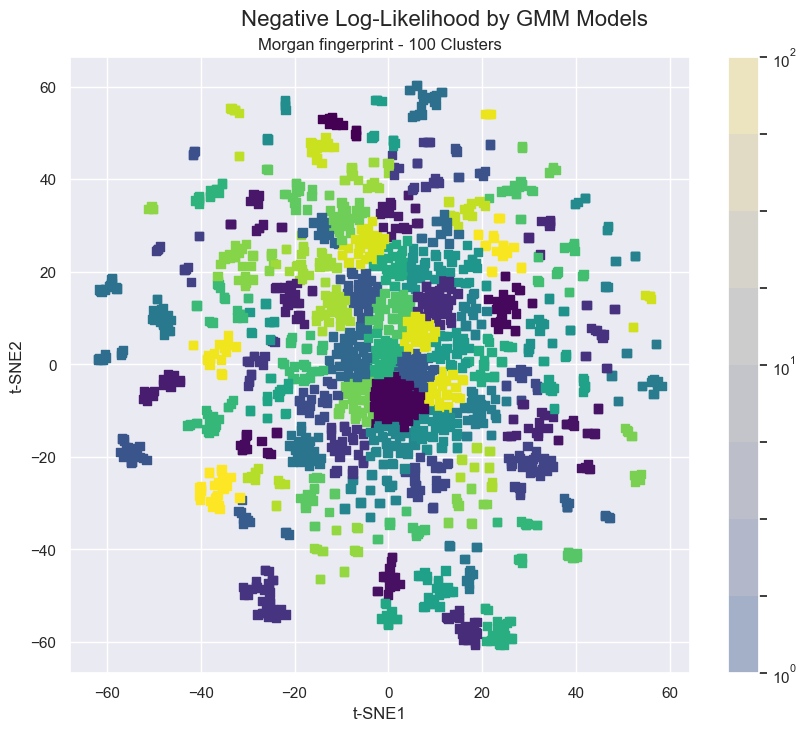

In [36]:
def cluster_with_GMM(X_train=all_drugs_morgan_fp, n_clusters=100):

    ## PART 1. Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data
    tsne = TSNE(n_components=2)
    X_train_tsne = tsne.fit_transform(X_train)

    # Vary the covariance matrix type 'spherical', 'diag', 'tied', 'full'
    cov_types = ['spherical', 'diag', 'tied', 'full']

    fig, ax = plt.subplots(figsize=(10, 8))
    plt.suptitle(f"Negative Log-Likelihood by GMM Models",
                 size=16, y=0.94)
    # Fit GMM model
    gmm = GaussianMixture(n_components=n_clusters, covariance_type=cov_types[2], random_state=12345)
    gmm.fit(X_train_tsne)
    y_hat = gmm.predict(X_train_tsne)

    # Plot density estimation
    X, Y = np.meshgrid(np.linspace(-3, 4), np.linspace(-3,4))
    XX = np.array([X.ravel(), Y.ravel()]).T

    # Get the negative weighted log-likelihood
    Z = -gmm.score_samples(XX)
    Z = Z.reshape(X.shape)
    CS = plt.contourf(X, Y, Z,
                    norm=LogNorm(vmin=1.0, vmax=100.0),
                    levels=np.logspace(0, 2, 9),
                    alpha=.3, cmap="cividis")
    plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_hat, marker="s", cmap="viridis")
    plt.title(f'Morgan fingerprint - {n_clusters} Clusters')
    plt.colorbar(CS)
    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.show()


cluster_with_GMM(X_train=all_drugs_morgan_fp, n_clusters=100)

### Morgan Embedding Using 300 Centroids' Fingerprints

In [13]:
def get_fingerprints(smiles, verbose=False, fingerprints='Morgan'):
    # Encode to molecule object
    mol = Chem.MolFromSmiles(smiles)

    if fingerprints == 'Morgan':
        # Generate morgan fingerprint
        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        except:
            fp = None

    if fingerprints == 'MACCS':
        # SMARTS-based MACCS Keys which is a simplified version (less bits) 166 keys
        try:
            fp = MACCSkeys.GenMACCSKeys(mol)
        except:
            fp = None

    if fingerprints == 'RDKit':
        # Topological Fingerprints
        try:
            fp = AllChem.RDKFingerprint(mol)
        except:
            fp = None

    if verbose:
        print('Fingerprint', fp.ToBitString())

    return fp

def ConsineSimilarity(fp1_arr, fp2_arr):
    """Calculate Cosine Similarity from fingerprints array"""
    # Convert bits array to idx of ones value
    fp1 = set(np.nonzero(fp1_arr)[0])
    fp2 = set(np.nonzero(fp2_arr)[0])

    # Count the number of bits that are both 1 in the two fingerprints
    intersection = len(fp1 & fp2)
    # Get the L1 length from two fingerprints
    product_length = np.sqrt(len(fp1)*len(fp2))
    # Return the ratio of intersection to union
    if product_length > 0:
        return round(intersection / product_length, 7)
    else:
        return 0

def TanimotoSimilarity(fp1_arr, fp2_arr):
    """Calculate Cosine Similarity from fingerprints array"""
    # Convert bits array to idx of ones value
    fp1 = set(np.nonzero(fp1_arr)[0])
    fp2 = set(np.nonzero(fp2_arr)[0])
    # Count the number of bits that are both 1 in the two fingerprints
    intersection = len(fp1 & fp2)
    # Count the Union
    union  = len(fp1) + len(fp2) - intersection
    # Return the ratio of intersection to union
    if union > 0:
        return round(intersection / union, 7)
    else:
        return 0

def embedding_fingerprints(smiles, fingerprints="Morgan", similarity="Cosine", basis=basis_300centroids):
    """
    Input: a SMILES string representation
    Output: Embedding from fingerprints & similarity
    Extracting Embedding Vector From Fingerprints & Similarity Type
        fingerprints: Morgan, RDKit, MACCS
        Similarity: Cosine, Tanimoto
    """
    # Extract fingerprints from smiles:
    try:
        fp1_arr = np.array(get_fingerprints(smiles, fingerprints=fingerprints))
    except:
        return None

    # Extract fingerprints basis matrix
    basis_matrix = basis[fingerprints]

    # Initialize embedding
    embedding = []

    # Calculate Similarity for drug fingerprint with the rest of the drugs in the basis
    for fp2_arr in basis_matrix:
        if similarity == "Cosine":
            drug_similarity = ConsineSimilarity(fp1_arr, fp2_arr)
        if similarity == "Tanimoto":
            drug_similarity = ConsineSimilarity(fp1_arr, fp2_arr)
        embedding.append(drug_similarity)

    # return np.array(embedding)
    return embedding

def create_embedding_all_drugs(drugs_smiles, fingerprint='Morgan', basis=basis_300centroids):
    """Create embedding for all drugs"""
    # Using Morgan fingerprints & Cosine similarity
    # fingerprints = ["Morgan", "RDKit", "MACCS"]
    similarities=["Cosine", "Tanimoto"]

    # Initialize
    sim_embeds = {}
    for similarity in similarities:
        # Initialize
        drug_embeddings = {}
        for drug_id in drugs_smiles.keys():
            # Extract drug smiles for each drug_id
            drug_smi = drugs_smiles[drug_id]

            # Extract embedding array for each fingerprint & similarity type
            embedding = embedding_fingerprints(drug_smi, fingerprints=fingerprint, similarity=similarity, basis=basis)
            if len(embedding) > 0:
                drug_embeddings[drug_id] = embedding

        # Update embedding for each similarity
        sim_embeds[similarity] = drug_embeddings

    return sim_embeds

In [71]:
### TEST BLOCK
# Extract embedding of the first drug using Morgan fingerprint & Cosine similarity
smiles1 = drugs_smiles['DB00215']
embedding_fingerprints(smiles1, fingerprints="Morgan", similarity="Tanimoto", basis=basis_100centroids)[:10]

[0.0326164,
 0.1956984,
 0.2062842,
 0.1597871,
 0.1935596,
 0.137679,
 0.1618227,
 0.2860648,
 0.1909821,
 0.1680849]

In [24]:
### CREATE MORGAN FINGERPRINT EMBEDDINGS FOR ALL DRUGS IN THE DATA
all_drug_morgan_embeddings = create_embedding_all_drugs(drugs_smiles, fingerprint='Morgan', basis=basis_768_centroids)
print("Morgan Fingerprint Embedding:")
print('All Similarity Types:', all_drug_morgan_embeddings.keys())
print('Example for first drug embedding with Morgan fingerprint & Cosine similarity:')
print(all_drug_morgan_embeddings["Tanimoto"]['DB00338'][:10])
print("Embedding dimension:", len(all_drug_morgan_embeddings["Tanimoto"]['DB00338']))

Morgan Fingerprint Embedding:
All Similarity Types: dict_keys(['Cosine', 'Tanimoto'])
Example for first drug embedding with Morgan fingerprint & Cosine similarity:
[0.0912871, 0.1540789, 0.1981485, 0.1091089, 0.1969316, 0.1108832, 0.1428869, 0.1705721, 0.1639025, 0.1020621]
Embedding dimension: 768


In [16]:
# Save as text file using similar format of word2vec embedding
def export_drug2vec(all_drug_embeddings, similarity="Tanimoto",file_name="weights/drug2vec_300clusters_morgan_tanimoto.txt"):
    with open(file_name, "w") as f:
        # First Row
        vocab_size = str(len(all_drug_embeddings[similarity].keys()))
        embed_len = str(len(list(all_drug_embeddings[similarity].values())[0]))
        embed_shape = vocab_size + ' ' + embed_len + '\n'
        f.write(embed_shape)

        # Embedding Rows
        for drug in all_drug_embeddings[similarity].keys():
            similarity_list = list(all_drug_embeddings[similarity][drug])
            similarity_str = ' '.join([str(x) for x in similarity_list])
            drug_embed = drug + ' ' + similarity_str + '\n'
            f.write(drug_embed)

In [25]:
# Export Morgan Similarity Embedding with Tanimoto Similarity to text file
export_drug2vec(all_drug_morgan_embeddings, similarity="Tanimoto",file_name="weights/drug2vec_768clusters_morgan_tanimoto.txt")

# Export Morgan Similarity Embedding with Cosine Similarity to text file
export_drug2vec(all_drug_morgan_embeddings, similarity="Cosine",file_name="weights/drug2vec_768clusters_morgan_cosine.txt")

### RDKit Embedding Using 300 Centroids' Fingerprints

In [26]:
### CREATE RDKIT FINGERPRINT EMBEDDINGS FOR ALL DRUGS IN THE DATA
all_drug_rdkit_embeddings = create_embedding_all_drugs(drugs_smiles, fingerprint='RDKit', basis=basis_768_centroids)
print("RDKit Fingerprint Embedding:")
print('All Similarity Types:', all_drug_rdkit_embeddings.keys())
print("First 10 drugs with RDKit fingerprint & Cosine similarity:", list(all_drug_rdkit_embeddings["Cosine"].keys())[:10])
print('Example for first drug embedding with RDKit fingerprint & Cosine similarity:')
# print(list(all_drug_rdkit_embeddings["Cosine"].values())[0][:10])
print(all_drug_rdkit_embeddings["Tanimoto"]['DB00338'][:10])
print('Embedding Dimension:', len(list(all_drug_rdkit_embeddings["Cosine"].values())[0]))

RDKit Fingerprint Embedding:
All Similarity Types: dict_keys(['Cosine', 'Tanimoto'])
First 10 drugs with RDKit fingerprint & Cosine similarity: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']
Example for first drug embedding with RDKit fingerprint & Cosine similarity:
[0.172322, 0.6132791, 0.2929528, 0.4755877, 0.6068762, 0.3202892, 0.3033458, 0.4445494, 0.5809925, 0.4611823]
Embedding Dimension: 768


In [27]:
# Export RDKit Embedding with Tanimoto Similarity to text file
export_drug2vec(all_drug_rdkit_embeddings, similarity="Tanimoto",file_name="weights/drug2vec_768clusters_rdkit_tanimoto.txt")

# Export RDKit Embedding with Cosine Similarity to text file
export_drug2vec(all_drug_rdkit_embeddings, similarity="Cosine",file_name="weights/drug2vec_768clusters_rdkit_cosine.txt")

### MACCS Keys Embedding Using 300 Centroids' Fingerprints

In [28]:
### CREATE MACCS KEYS FINGERPRINT EMBEDDINGS FOR ALL DRUGS IN THE DATA
all_drug_maccs_embeddings = create_embedding_all_drugs(drugs_smiles, fingerprint='MACCS', basis=basis_768_centroids)
print("MACCS Keys Fingerprint Embedding:")
print('All Similarity Types:', all_drug_maccs_embeddings .keys())
print("First 10 drugs with MACCS Keys fingerprint & Cosine similarity:", list(all_drug_maccs_embeddings ["Cosine"].keys())[:10])
print('Example for first drug embedding with MACCS Keys fingerprint & Cosine similarity:')
# print(list(all_drug_maccs_embeddings["Cosine"].values())[0][:10])
print(all_drug_maccs_embeddings["Tanimoto"]['DB00338'][:10])
print('Embedding Dimension:', len(list(all_drug_maccs_embeddings["Cosine"].values())[0]))

MACCS Keys Fingerprint Embedding:
All Similarity Types: dict_keys(['Cosine', 'Tanimoto'])
First 10 drugs with MACCS Keys fingerprint & Cosine similarity: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']
Example for first drug embedding with MACCS Keys fingerprint & Cosine similarity:
[0.5948119, 0.3512197, 0.0, 0.5468166, 0.6472695, 0.4686999, 0.2931977, 0.5602884, 0.586294, 0.4543109]
Embedding Dimension: 768


In [29]:
# Export MACCS KEYS Embedding with Tanimoto Similarity to text file
export_drug2vec(all_drug_maccs_embeddings, similarity="Tanimoto",file_name="weights/drug2vec_768clusters_maccs_tanimoto.txt")

# Export MACCS KEYS Embedding with Cosine Similarity to text file
export_drug2vec(all_drug_maccs_embeddings, similarity="Cosine",file_name="weights/drug2vec_768clusters_maccs_cosine.txt")